In [143]:
import soccerdata as sd
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as pd
import numpy as np
import pyarrow
import seaborn as sb
import csv
import os
from mplsoccer import VerticalPitch, Pitch
import math

In [144]:
"""player_list = []
import socceraction.spadl as spadl
for i in range(len(games)):
    gamepath = games[i]
    game = pd.read_csv(DIR+'/'+gamepath)
    the_id = game.game_id
    the_id = the_id[0]
    the_id = the_id.item()
    loader = ws.read_events(match_id = the_id, output_fmt="loader")
    player = loader.players(the_id)
    player_list.append(player)
    path = f'games_players/{the_id}_players.csv'
    player.to_csv(path)
    i+=1"""

'player_list = []\nimport socceraction.spadl as spadl\nfor i in range(len(games)):\n    gamepath = games[i]\n    game = pd.read_csv(DIR+\'/\'+gamepath)\n    the_id = game.game_id\n    the_id = the_id[0]\n    the_id = the_id.item()\n    loader = ws.read_events(match_id = the_id, output_fmt="loader")\n    player = loader.players(the_id)\n    player_list.append(player)\n    path = f\'games_players/{the_id}_players.csv\'\n    player.to_csv(path)\n    i+=1'

In [145]:
def player_details(game_id):
    id = game_id.item()
    ws = ws = sd.WhoScored(leagues="ENG-Premier League", seasons=2025)
    print(type(ws))
    loader = ws.read_events(match_id = id, output_fmt="loader")
    player = loader.players(id)
    return player

In [146]:
def find_opp(df):
    teams = df['team'].sort_values().to_list()
    opposition = ''
    if teams[0] == 'Man Utd':
        print('Man Utd = teams[0]')
        return teams[-1]
    else:
        return  teams[0]
    print('Man Utd = teams[-1]')

In [147]:
def splitter(df):
    return_df = df[(df['type'] == 'Pass') & (df['outcome_type'] == 'Successful')]
    return_df['x']*=1.2
    return_df['end_x']*=1.2
    return_df['y']*=0.8
    return_df['end_y']*=0.8
    return_df.insert(1, "pass_angle",
                      np.degrees(np.arctan2(
                        return_df['end_y'] - return_df['y'],
                        return_df['end_x'] - return_df['x']
                      ))
                     )
    return_df.insert(2, "pass_angle_abs",
                     np.abs(return_df['pass_angle'])
                     )
    return_df.insert(3, 'receiver',
                     return_df['player_id'].shift(-1)
                     )
    return return_df

In [148]:
def pass_comb(df):
    df['pos_min'] = df[['player_id', 'receiver']].min(axis = 1)
    df['pos_max'] = df[['player_id', 'receiver']].min(axis = 1)

    passing_comb = df.groupby(['pos_min', 'pos_max']).size().reset_index(name='pass_count')

    return passing_comb

In [149]:
def enhance_position(passdf, game_id ,list_players):
    avg_locs = passdf.groupby('player_id').agg({
        'x': 'median',
        'y': 'median',
        'player_id': 'count'
    })
    id = str(game_id)
    path = 'games_players/'+id+'_players.csv'
    game = pd.read_csv(path)
    avg_locs.columns = ['x_avg', 'y_avg', 'pass_count']
    avg_locs = avg_locs.join(game)
    return avg_locs

In [150]:
def team_metric(df, location, team_id):
    passes = df
    valid_pass = passes[
        (passes['pass_angle_abs'] >= 0)&
        (passes['pass_angle_abs'] <= 90)
    ]
    print(location.columns)
    median_angle = valid_pass['pass_angle_abs'].median()
    verticality = round((1 - median_angle/90) * 100, 2)
    center_backs = location[location['starting_position'] == 'DC']
    defense_line = center_backs['x_avg'].median() if len(center_backs) > 0 else 30

    attackers = location[location['starting_position'].isin(['FW', 'AMC'])]
    forward_line = attackers['x_avg'].mean() if len(attackers) > 0 else 90
    team_median = location['x_avg'].median()

    return {
        'verticality': verticality,
        'defense_line': defense_line,
        'forward_line': forward_line,
        'team_median': team_median
    }


In [151]:
def tem_metric(df, location, team_id):
    passes = df
    valid_pass = passes[
        (passes['pass_angle_abs'] >= 0)&
        (passes['pass_angle_abs'] <= 90)
    ]
    median_angle = valid_pass['pass_angle_abs'].median()
    verticality = round((1 - median_angle/90) * 100, 2)
    center_backs = location[location['starting_position'] == 'DC']
    defense_line = center_backs['x_avg'].median() if len(center_backs) > 0 else 30

    attackers = location[location['starting_position'].isin(['FW', 'AMC'])]
    forward_line = attackers['x_avg'].mean() if len(attackers) > 0 else 90
    team_median = location['x_avg'].median()

    return {
        'verticality': verticality,
        'defense_line': defense_line,
        'forward_line': forward_line,
        'team_median': team_median
    }


In [152]:
def plotter(ax, passes_df, avg_locs, pass_combinations, team_metrics,
                         team_name, color='blue',bg_color='#0C0D0E'):
    pitch = Pitch(pitch_type='statsbomb', line_color='white', pitch_color=bg_color, linewidth=1)
    pitch.draw(ax=ax)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)
    ax.set_facecolor(bg_color)

    combinations = pass_combinations.merge(
        avg_locs[['x_avg', 'y_avg', 'player_name']],
        left_on='pos_min', right_index=True
    ).merge(
        avg_locs[['x_avg', 'y_avg', 'player_name']],
        left_on='pos_max', right_index=True,
        suffixes=['', '_end']
    )

    max_passes = combinations['pass_count'].max()
    combinations['line_width'] = (combinations['pass_count'] / max_passes) * 15
    combinations['alpha'] = 0.3 + (combinations['pass_count'] / max_passes) * 0.6

    for _, row in combinations.iterrows():
        pitch.lines(row['x_avg'], row['y_avg'], row['x_avg_end'], row['y_avg_end'],
                   lw=row['line_width'], color=color, alpha=row['alpha'], ax=ax, zorder=1)

    # Tactical lines - also transform for away team
    defense_line = team_metrics['defense_line']
    forward_line = team_metrics['forward_line']
    team_median = team_metrics['team_median']

    # Draw tactical lines (lighter gray for dark background)
    ax.axvline(x=defense_line, color='lightgray', linestyle='dotted', alpha=0.6, linewidth=2, zorder=2)
    ax.axvline(x=forward_line, color='lightgray', linestyle='dotted', alpha=0.6, linewidth=2, zorder=2)
    ax.axvline(x=team_median, color='lightgray', linestyle='--', alpha=0.8, linewidth=2, zorder=2)

    # Highlight middle zone
    min_line = min(defense_line, forward_line)
    max_line = max(defense_line, forward_line)
    ymid = [0, 0, 80, 80]
    xmid = [min_line, max_line, max_line, min_line]
    ax.fill(xmid, ymid, color, alpha=0.1, zorder=0)

    for player_id, row in avg_locs.iterrows():
        marker = 'o' if row['is_starter'] else 's'
        pitch.scatter(row['x_avg'], row['y_avg'], s=1200, marker=marker,
                     color='white', edgecolors=color, linewidth=3, ax=ax, zorder=3)

        ax.text(row['x_avg'], row['y_avg'], str(row['jersey_number']),
                ha='center', va='center', fontsize=14, color=color, weight='bold', zorder=4)

    ax.text(115, 75, "○ = starter\n□ = substitute",
            fontsize=11, ha='right', va='top', color='white',
            bbox=dict(boxstyle="round,pad=0.3", facecolor=bg_color, edgecolor='white', alpha=0.8))
    ax.text(10, -8, f"Verticality: {team_metrics['verticality']}%",
            fontsize=12, ha='left', color='white', weight='bold')
    ax.text(70, -8, f"Median: {team_metrics['team_median']:.1f}m",
            fontsize=12, ha='left', color='white', weight='bold')

    ax.set_title(f"{team_name} - Passing Network", fontsize=14, color='white')

[01/02/26 12:43:24] INFO     Saving cached data to C:\Users\User\soccerdata\data\WhoScored           ]8;id=453802;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=678177;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

<class 'soccerdata.whoscored.WhoScored'>


[01/02/26 12:44:32] INFO     Retrieving calendar for ENG-Premier League 2526                       ]8;id=788851;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=274780;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#374\374]8;;\

[01/02/26 12:44:46] INFO     [1/10] Retrieving fixtures for ENG-Premier League 2526                ]8;id=56631;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=845622;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#403\403]8;;\

[01/02/26 12:44:55] INFO     [2/10] Retrieving fixtures for ENG-Premier League 2526                ]8;id=712328;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=252887;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#403\403]8;;\

[01/02/26 12:45:03] INFO     [3/10] Retrieving fixtures for ENG-Premier League 2526                ]8;id=153133;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=980783;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#403\403]8;;\

[01/02/26 12:45:12] INFO     [4/10] Retrieving fixtures for ENG-Premier League 2526                ]8;id=904394;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=113823;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#403\403]8;;\

[01/02/26 12:45:20] INFO     [5/10] Retrieving fixtures for ENG-Premier League 2526                ]8;id=204365;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=60586;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#403\403]8;;\

[01/02/26 12:45:29] INFO     [6/10] Retrieving fixtures for ENG-Premier League 2526                ]8;id=647180;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=123714;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#403\403]8;;\

[01/02/26 12:45:41] INFO     [7/10] Retrieving fixtures for ENG-Premier League 2526                ]8;id=460766;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=47227;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#403\403]8;;\

[01/02/26 12:45:50] INFO     [8/10] Retrieving fixtures for ENG-Premier League 2526                ]8;id=201610;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=967552;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#403\403]8;;\

[01/02/26 12:46:00] INFO     [9/10] Retrieving fixtures for ENG-Premier League 2526                ]8;id=294046;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=910383;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#403\403]8;;\

[01/02/26 12:46:07] INFO     [10/10] Retrieving fixtures for ENG-Premier League 2526               ]8;id=616130;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=283586;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#403\403]8;;\

[01/02/26 12:46:17] WARNING  C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=977862;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=363108;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\whoscored.py:427: FutureWarning: The behavior of                         
                             DataFrame concatenation with empty or all-NA entries is deprecated. In                
                             a future version, this will no longer exclude empty or all-NA columns                 
                             when determining the result dtypes. To retain the old behavior,                       
                             exclude the relevant entries before the concat operation.                             
                               pd.concat(all_schedules)                                                            
                                                                                                                   

                    INFO     [1/1] Retrieving game with id=1903125                                 ]8;id=212262;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=178569;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#695\695]8;;\

                    WARNING  C:\Users\User\AppData\Local\Temp\ipykernel_3104\3684630457.py:3:       ]8;id=830271;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=360352;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               return_df['x']*=1.2                                                                 
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Temp\ipykernel_3104\3684630457.py:4:       ]8;id=421969;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=977519;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               return_df['end_x']*=1.2                                                             
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Temp\ipykernel_3104\3684630457.py:5:       ]8;id=825772;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=53752;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               return_df['y']*=0.8                                                                 
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Temp\ipykernel_3104\3684630457.py:6:       ]8;id=100611;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=687012;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               return_df['end_y']*=0.8                                                             
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Temp\ipykernel_3104\3684630457.py:3:       ]8;id=331298;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=954843;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               return_df['x']*=1.2                                                                 
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Temp\ipykernel_3104\3684630457.py:4:       ]8;id=947234;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=761437;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               return_df['end_x']*=1.2                                                             
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Temp\ipykernel_3104\3684630457.py:5:       ]8;id=515299;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=944489;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               return_df['y']*=0.8                                                                 
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Temp\ipykernel_3104\3684630457.py:6:       ]8;id=135596;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=143490;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               return_df['end_y']*=0.8                                                             
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Temp\ipykernel_3104\4001725883.py:2:       ]8;id=783221;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=200248;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['pos_min'] = df[['player_id', 'receiver']].min(axis = 1)                         
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Temp\ipykernel_3104\4001725883.py:3:       ]8;id=852352;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=709235;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['pos_max'] = df[['player_id', 'receiver']].min(axis = 1)                         
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Temp\ipykernel_3104\4001725883.py:2:       ]8;id=321809;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=960306;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['pos_min'] = df[['player_id', 'receiver']].min(axis = 1)                         
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Temp\ipykernel_3104\4001725883.py:3:       ]8;id=766217;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=562029;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['pos_max'] = df[['player_id', 'receiver']].min(axis = 1)                         
                                                                                                                   

Index(['x_avg', 'y_avg', 'pass_count', 'Unnamed: 0', 'game_id', 'team_id',
       'player_id', 'player_name', 'is_starter', 'minutes_played',
       'jersey_number', 'starting_position'],
      dtype='object')
Index(['x_avg', 'y_avg', 'pass_count', 'Unnamed: 0', 'game_id', 'team_id',
       'player_id', 'player_name', 'is_starter', 'minutes_played',
       'jersey_number', 'starting_position'],
      dtype='object')


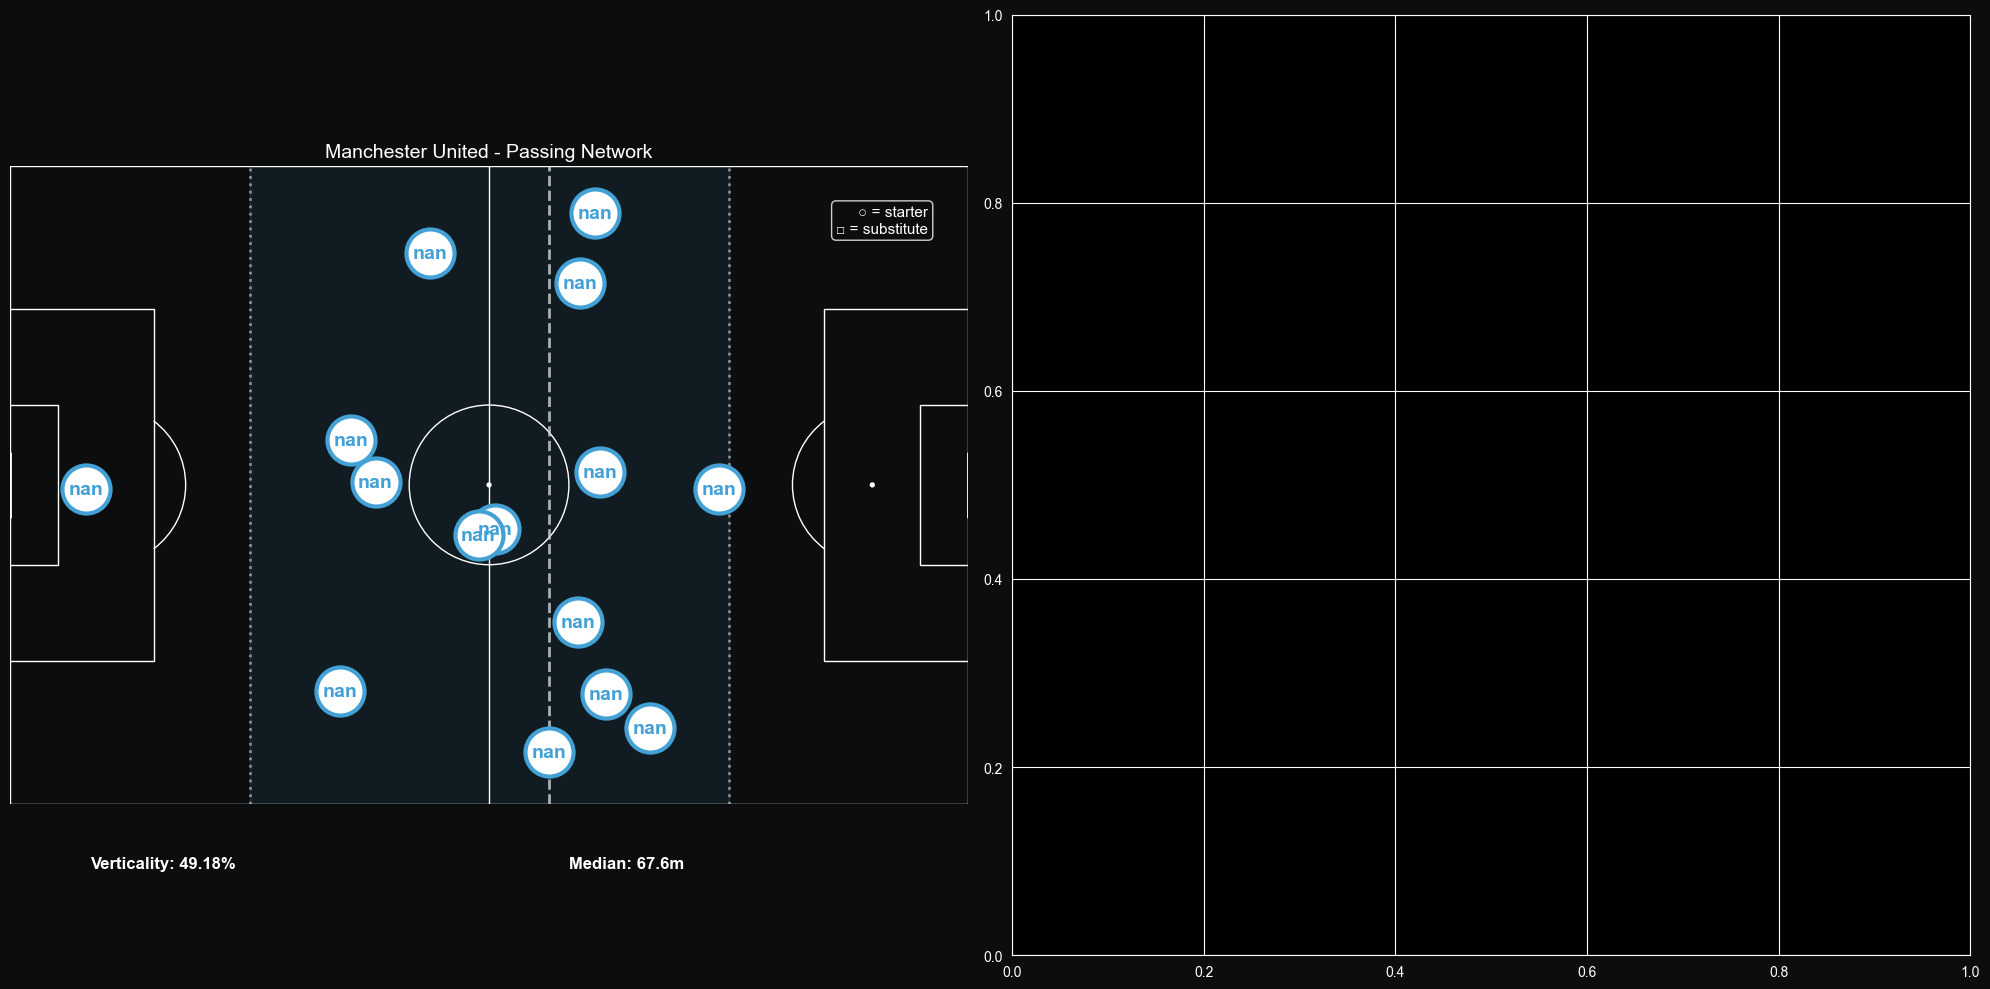

In [153]:
DIR = 'utd_games'
num = sum(os.path.isfile(os.path.join(DIR, name)) for name in os.listdir(DIR))
games = []
for i in range(num):
    games.append(os.listdir(DIR)[i])
game = pd.read_csv(DIR+'/'+games[0])
gameId = game.game_id[0]
gameId = gameId.astype(int)

players_df = player_details(gameId)

pass_df = game[['team','player','player_id','minute','type','outcome_type','second','x', 'y','end_x','end_y']]

opposition = find_opp(pass_df)
mutd_df = pass_df[pass_df['team'] == 'Man Utd']
opposition_df = pass_df[pass_df['team'] == opposition]

mutd_pass_df = splitter(mutd_df)
opposition_pass_df = splitter(opposition_df)

mutd_pass_comb = pass_comb(mutd_pass_df)
opposition_pass_comb = pass_comb(opposition_pass_df)

mutd_avg_location = enhance_position(mutd_pass_df, gameId, mutd_pass_comb)
opposition_avg_location = enhance_position(opposition_pass_df, gameId, opposition_pass_comb)

mutd_team_metric = team_metric(mutd_pass_df, mutd_avg_location ,gameId)
opposition_team_metric = team_metric(opposition_pass_df, opposition_avg_location ,gameId)

# THE ATHLETIC STYLING
background_color = '#0C0D0E'  # The Athletic's dark background
home_color = '#43A1D5'       # Keep your blue but it'll pop on dark background
away_color = '#FF4C4C'       # Keep your red

# Plot with Athletic styling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.patch.set_facecolor(background_color)  # Dark background for entire figure

plotter(ax1, mutd_df, mutd_avg_location, mutd_pass_comb, mutd_team_metric,
                     'Manchester United', color=home_color, bg_color=background_color)


plt.tight_layout()

plt.show()

In [154]:
"""
Index(['x_avg', 'y_avg', 'pass_count', 'Unnamed: 0', 'game_id', 'team_id',
       'player_id', 'player_name', 'is_starter', 'minutes_played',
       'jersey_number', 'starting_position'],
      dtype='object')
"""

"\nIndex(['x_avg', 'y_avg', 'pass_count', 'Unnamed: 0', 'game_id', 'team_id',\n       'player_id', 'player_name', 'is_starter', 'minutes_played',\n       'jersey_number', 'starting_position'],\n      dtype='object')\n"